In [1]:
# imports
import os
import csv
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras import layers
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow import keras
from tensorflow.keras import layers
print('done!')

done!


In [2]:
# put everything into a dict

# make list of file names
file_names = ['charlotte_sim_1_cooltoofast_combined_interpolated.csv', 'charlotte_sim_1_lowpeaktemp_combined_interpolated.csv',
              'charlotte_sim_1_lowtemps_combined_interpolated.csv','charlotte_sim_1_successful_combined_interpolated.csv', 
              'charlotte_sim_2_successful_combined_interpolated.csv',
              'charlotte_sim_2_v2_combined_interpolated.csv', 'charlotte_sim_3_combined_interpolated.csv',
              'denver_sim_1_combined_interpolated.csv', 'denver_sim_2_combined_interpolated.csv','denver_sim_3_combined_interpolated.csv',
              'detroit_sim_1_combined_interpolated.csv', 'detroit_sim_2_incomplete_combined_interpolated.csv', 
              'detroit_sim_2_successful_combined_interpolated.csv','detroit_sim_3_combined_interpolated.csv',
              'jacksonville_sim_1_combined_interpolated.csv', 'jacksonville_sim_2_combined_interpolated.csv',
              'jacksonville_sim_3_combined_interpolated.csv', 'lasvegas_sim_1_combined_interpolated.csv',
              'lasvegas_sim_2_combined_interpolated.csv', 'lasvegas_sim_3_combined_interpolated.csv']

# declare the dict 
file_dict = dict()
file_dict_len = len(file_names)
# loop through file names, open then, convert to list, and add to dict as a numpy array with i as the key
for i in range(file_dict_len):
    with open(file_names[i], "r") as f:
        reader = pd.read_csv(f)
        # exclude heater due to errors and sensor/motor times
        reader.drop(['heater','Sensor Time', 'Motor Time'], inplace = True, axis = 1)
        file_data = [list(x) for x in reader.values]
        file_dict[i] = file_data
# check the conversion
# print(file_dict[0])
print("done!")


done!


In [3]:
# combine train files and test files into separate lists
full_train_x_set = [None] * 4500
full_train_y_set = [None] * 4500
full_test_x_set = [None] * 2000
full_test_y_set = [None] * 2000
trainInd = 0
testInd = 0

for i in range(0,file_dict_len - 5):
    for j in range(0,len(file_dict[i])):
        #print(file_dict[i][j])
        full_train_x_set[trainInd] = file_dict[i][j]
        full_train_y_set[trainInd] = file_dict[i][j][0:16]
        trainInd += 1

for i in range(file_dict_len - 5, file_dict_len):
    for j in range(0, len(file_dict[i])):
        full_test_x_set[testInd] = file_dict[i][j]
        full_test_y_set[testInd] = file_dict[i][j][0:16]
        testInd += 1

# filter the Nones out of the lists
filtered_train_x_set = list(filter(None,full_train_x_set))
filtered_train_y_set = list(filter(None, full_train_y_set))
filtered_test_x_set = list(filter(None,full_test_x_set))
filtered_test_y_set = list(filter(None,full_test_y_set))
#print(filtered_train_set[len(filtered_train_set) - 5: len(filtered_train_set)])

# scale all the data 
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
scaled_train_x = x_scaler.fit_transform(filtered_train_x_set)
scaled_train_y = y_scaler.fit_transform(filtered_train_y_set)
scaled_test_x = x_scaler.transform(filtered_test_x_set)
scaled_test_y = y_scaler.transform(filtered_test_y_set)

#print(scaled_train[len(scaled_train) - 5: len(scaled_train)])
#print(scaled_test_y)
print("done!")


done!


In [4]:
# fix random seed so this can be reproduced
seed_val = 7
def reset_random_seeds():
    tf.random.set_seed(seed_val)
    np.random.seed(seed_val)
    random.seed(seed_val)
    
reset_random_seeds()

In [5]:
# setting some specifications for model based on our data
num_features = 34 # i think this is number of variables but im not 100% sure
batch_size = 64 # the number of chunks of data being fed into the ml algorithm at a time (always a power of 2)
time_steps = 10 # the size of each chunk of data being fed into the ml algorithm
shift_steps = 15 # the number of cells to shift the y values so the predictions line up with the current data
train_percent = 0.8 # the percentage of the input files to set aside for training

In [6]:
# ** converting all training data into batches and putting it into a file **
# use the lengths of the files to get the indicies
print('start')
def train_batches(time_steps, shift_steps):
    # for each file
    train_set = [[None for x in range(2)] for i in range(4096)]
    file_sum = 0
    ind = 0
    for i in range(file_dict_len - 5):
        # get num rows 
        current_len = len(file_dict[i])
        # start at i and i + 15 (j)
        for j in range(file_sum, file_sum + current_len - shift_steps + 1):
            #print(ind)
            train_set[ind][0] = scaled_train_x[j:j + time_steps]
            temp = scaled_train_x[j + shift_steps - 1: j + shift_steps]
            train_set[ind][1] = temp[0][0:16]
            #print(train_set[ind][0])
            ind += 1
        file_sum += current_len        
    return train_set

train_set = train_batches(time_steps, shift_steps)
train_set = train_set[0:len(train_set) - 85][0:len(train_set)- 85]
#print(train_set[len(train_set) - 5: len(train_set)])
#train_set = np.array(train_set)

with open('train_batches.csv', "w", newline = "") as x:
    writeX = csv.writer(x)
    writeX.writerows(train_set) 
    
print('done!')

start
done!


In [7]:
# ** converting all testing data into batches and putting it into a file **
print('start')

def test_batches(time_steps, shift_steps):
    # for each file
    test_set = [[None for x in range(2)] for i in range(2046)]
    file_sum = 0
    ind = 0
    for i in range(file_dict_len - 5, file_dict_len):
        # get num rows 
        current_len = len(file_dict[i])
        # start at i and i + 15 (j)
        for j in range(file_sum, file_sum + current_len - shift_steps + 1):
            #print(ind)
            test_set[ind][0] = scaled_test_x[j:j + time_steps]
            temp = scaled_test_x[j + shift_steps - 1: j + shift_steps]
            test_set[ind][1] = temp[0][0:16]
            #print(test_set[ind][0])
            ind += 1
        file_sum += current_len        
    return test_set

test_set = test_batches(time_steps, shift_steps)
test_set = test_set[0:len(test_set) - 545][0:len(test_set) - 545]
#print(test_set[len(test_set) - 5:len(test_set)])
#test_set = np.array(test_set)

with open('test_batches.csv', "w", newline = "") as x:
    writeX = csv.writer(x)
    writeX.writerows(test_set)
    
print('done!')

start
done!


In [8]:
# shuffle test and train
train_set = np.array(train_set)
test_set = np.array(test_set)

np.random.shuffle(train_set)
np.random.shuffle(test_set)

# split into x and y
x_train = [train_set[i][0] for i in range(len(train_set))]
x_train = np.array(x_train)
y_train = [train_set[i][1] for i in range(len(train_set))]
y_train = np.array(y_train)
#y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

x_test = [test_set[i][0] for i in range(len(test_set))]
x_test = np.array(x_test)
y_test = [test_set[i][1] for i in range(len(test_set))]
y_test = np.array(y_test)
#y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],1)

# check the shapes
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(4011, 10, 34)
(4011, 16)
(1501, 10, 34)
(1501, 16)


<ipython-input-8-266f6cd00963>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_set = np.array(train_set)
<ipython-input-8-266f6cd00963>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  test_set = np.array(test_set)


Epoch 1/50
63/63 [==============================] - 51s 47ms/step - loss: 0.3691 - val_loss: 0.3092
Epoch 2/50
63/63 [==============================] - 1s 12ms/step - loss: 0.2222 - val_loss: 0.1715
Epoch 3/50
63/63 [==============================] - 1s 11ms/step - loss: 0.1190 - val_loss: 0.0874
Epoch 4/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0603 - val_loss: 0.0472
Epoch 5/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0343 - val_loss: 0.0310
Epoch 6/50
63/63 [==============================] - 1s 12ms/step - loss: 0.0244 - val_loss: 0.0236
Epoch 7/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0197 - val_loss: 0.0192
Epoch 8/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0164 - val_loss: 0.0164
Epoch 9/50
63/63 [==============================] - 1s 12ms/step - loss: 0.0139 - val_loss: 0.0143
Epoch 10/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0118 - val_loss: 0.0127
Epoch 11

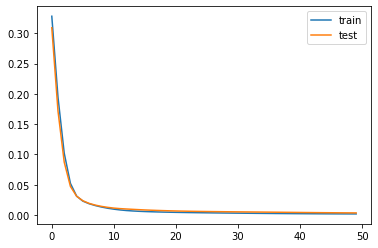

done!


In [9]:
# make the network
model = Sequential()
model.add(LSTM(4, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(16))
opt = keras.optimizers.Adam(learning_rate=0.005)
#optimizer = SGD(learning_rate = 0.01, nesterov=True, momentum=0.9)

model.compile(loss='mean_squared_error', optimizer = 'adam')

# fit the network
history = model.fit(x_train, y_train, epochs=50, batch_size=batch_size, validation_data=(x_test, y_test), verbose = 1, shuffle=False)

model.summary()
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# make predictions
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

print('done!')

In [10]:
# print(train_pred)

# scale the predictions back
train_pred = y_scaler.inverse_transform(train_pred)
y_train = y_scaler.inverse_transform(y_train)

test_pred = y_scaler.inverse_transform(test_pred)
y_test = y_scaler.inverse_transform(y_test)

# get RMSE
trainScore = math.sqrt(mean_squared_error(y_train[:,0], train_pred[:,0])) 
testScore = math.sqrt(mean_squared_error(y_test[:,0], test_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.47 RMSE
Test Score: 0.79 RMSE


In [13]:
print(train_pred.shape)
with open('predictions.csv', "w", newline = "") as p:
    writeP = csv.writer(p)
    writeP.writerows(test_pred)
    
print('done!')

(4011, 16)
done!


start


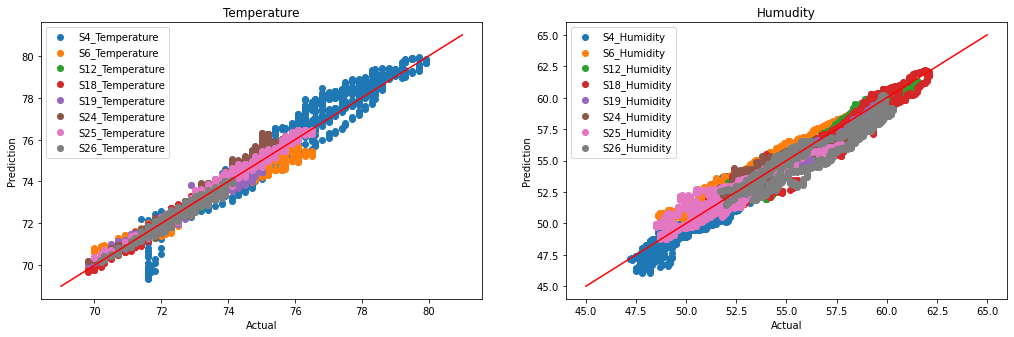

done


In [41]:
print('start')
fig = plt.figure(figsize = (15,10), )

ax1 = fig.add_subplot(222, label = '1')
ax2 = fig.add_subplot(221, label = '2')


# make the first axes "current" again
#plt.subplot(221)
labels = ["S4_Humidity","S4_Temperature","S6_Humidity","S6_Temperature","S12_Humidity","S12_Temperature","S18_Humidity",
          "S18_Temperature","S19_Humidity","S19_Temperature","S24_Humidity","S24_Temperature","S25_Humidity","S25_Temperature",
          "S26_Humidity","S26_Temperature"]
for i in range(0,y_test.shape[1],2):
    ax1.scatter(y_test[:,i], test_pred[:,i], label = labels[i])
    ax2.scatter(y_test[:,i + 1], test_pred[:, i + 1], label = labels[i + 1])
#plt.scatter(y_test, test_pred)
ax1.plot([45, 65], [45, 65], color = 'red')
ax2.plot([69, 81], [69, 81], color = 'red')
ax1.set_title('Humudity')
ax2.set_title('Temperature')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Prediction')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Prediction')
fig.tight_layout(pad = 4.0)
ax1.legend()
ax2.legend()
plt.show()
fig.savefig('LSTM_no_time_temp_hum_graphs2.png')
print('done')
#plt.plot(test_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def grid_search(model, param_dict, train_data, train_y):
    grid = GridSearchCV(model, param_dict, n_jobs=8)
    grid.fit(train_data, train_y)
    print(grid.best_params_)
    
    return grid

rfg_params = {'n_estimators': list(range(75, 225, 25)),
              'max_depth': [2,3,4,5],
              'criterion':['mse', 'mae']}
              
'''

rfg_params = {'n_estimators': list(range(75, 125, 25)),
              'max_depth': [2,3],
              'criterion':['mse']}
'''

svr_params = {'kernal' : ['linear', 'poly', 'rbf'],
              'degree': [2,3], 
              'epsilon': [0.05, 0.1, 0.15, 0.2]}

knn_params = {'n_neighbors': list(range(4,11)), 'weights': ['uniform', 'distance']}

xgb_params = {''}


model = RandomForestRegressor()
train_flatten = np.reshape(x_train, [x_train.shape[0],x_train.shape[1]*x_train.shape[2]])
train_flatten.shape
best_model = grid_search(model, rfg_params, train_flatten, y_train)
